In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
print("All required packages are installed.")

All required packages are installed.


In [3]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

sys.path.append(os.getcwd())

from src.image_loader import ImageLoader
from src.preprocessor import ImagePreprocessor
from src.feature_extractor import FeatureExtractor

### Config

In [4]:
preprocessor = ImagePreprocessor()
extractor = FeatureExtractor()

In [5]:
def process_dataset(category_name):
    """
    Przetwarza zdjęcia z folderu data/{category_name} 
    i zapisuje wyniki do output/{category_name}_processed.
    Zwraca DataFrame z wynikami dla tej kategorii.
    """
    
    # 1. Ustalanie ścieżek
    input_dir = os.path.join("data", category_name)
    output_dir = os.path.join("output", f"{category_name}_processed")
    
    print(f"\n--- Rozpoczynam analizę kategorii: {category_name.upper()} ---")
    print(f"Wejście: {input_dir}")
    print(f"Wyjście: {output_dir}")
    
    # Inicjalizacja loadera dla konkretnego folderu
    loader = ImageLoader(input_dir)
    category_results = []
    
    # 2. Pętla po zdjęciach
    for filename, img in loader.load_images():
        # print(f"Przetwarzanie: {filename}")  # Opcjonalne: odkomentuj, by widzieć każdy plik
        
        # A. Preprocessing
        gray = preprocessor.to_gray(img)
        
        # Wybieramy metodę CLAHE (Twoją), bo lepiej radzi sobie z teksturą
        enhanced = preprocessor.enhance_contrast_clahe(gray) 
        
        # B. Segmentacja (Maska) - Entropia
        mask = preprocessor.generate_mask_entropy(enhanced)
        
        # C. Ekstrakcja cech
        features, contour = extractor.extract(img, mask)
        
        if features:
            # Dodajemy metadane (nazwa pliku i kategoria/klasa)
            features['filename'] = filename
            features['label'] = category_name  # To pozwoli nam rozróżnić dane w wykresach!
            
            category_results.append(features)
            
            # D. Wizualizacja i Zapis
            # Rysujemy kontur na oryginale dla podglądu
            viz_img = img.copy()
            cv2.drawContours(viz_img, [contour], -1, (0, 255, 0), 2)
            
            # Zapisujemy maskę i wynik
            loader.save_image(output_dir, filename, mask, suffix="mask")
            loader.save_image(output_dir, filename, viz_img, suffix="result")
            
    df = pd.DataFrame(category_results)
    print(f"Zakończono {category_name}. Przetworzono {len(df)} obrazów.")
    return df

In [6]:
# 1. Przetwarzanie HEALTHY
df_healthy = process_dataset("healthy")

# 2. Przetwarzanie CANCER
df_cancer = process_dataset("cancer")
df_all = pd.concat([df_healthy, df_cancer], ignore_index=True)


--- Rozpoczynam analizę kategorii: HEALTHY ---
Wejście: data\healthy
Wyjście: output\healthy_processed
Zakończono healthy. Przetworzono 25 obrazów.

--- Rozpoczynam analizę kategorii: CANCER ---
Wejście: data\cancer
Wyjście: output\cancer_processed
Zakończono cancer. Przetworzono 14 obrazów.


### Data analysis

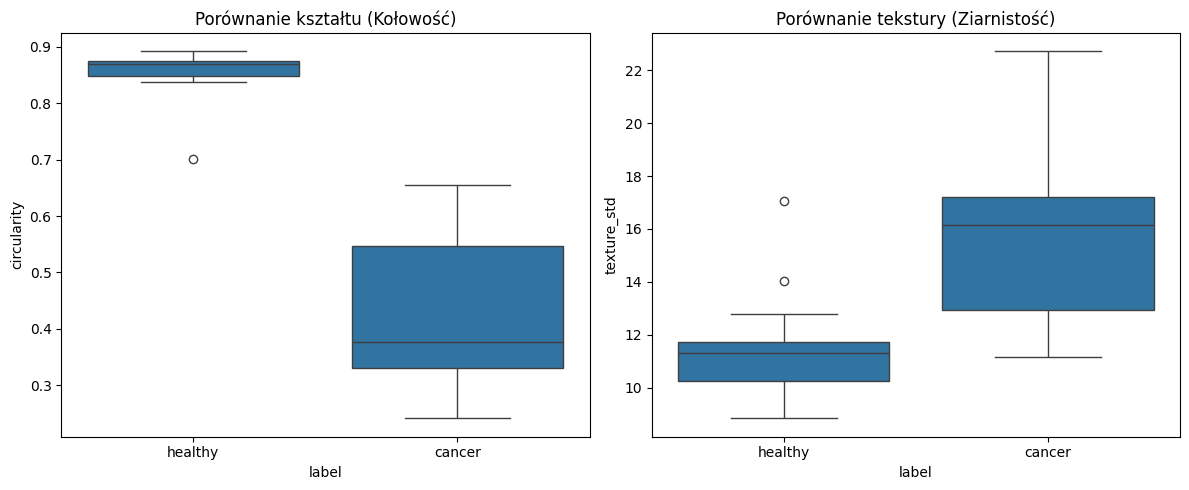

In [7]:
if not df_all.empty:
    plt.figure(figsize=(12, 5))
    
    # Porównanie kołowości (circularity) - komórki rakowe często mają nieregularny kształt
    plt.subplot(1, 2, 1)
    sns.boxplot(x='label', y='circularity', data=df_all)
    plt.title("Porównanie kształtu (Kołowość)")
    
    # Porównanie tekstury (odchylenie standardowe) - rakowe mogą być bardziej 'ziarniste'
    plt.subplot(1, 2, 2)
    sns.boxplot(x='label', y='texture_std', data=df_all)
    plt.title("Porównanie tekstury (Ziarnistość)")
    
    plt.tight_layout()
    plt.show()

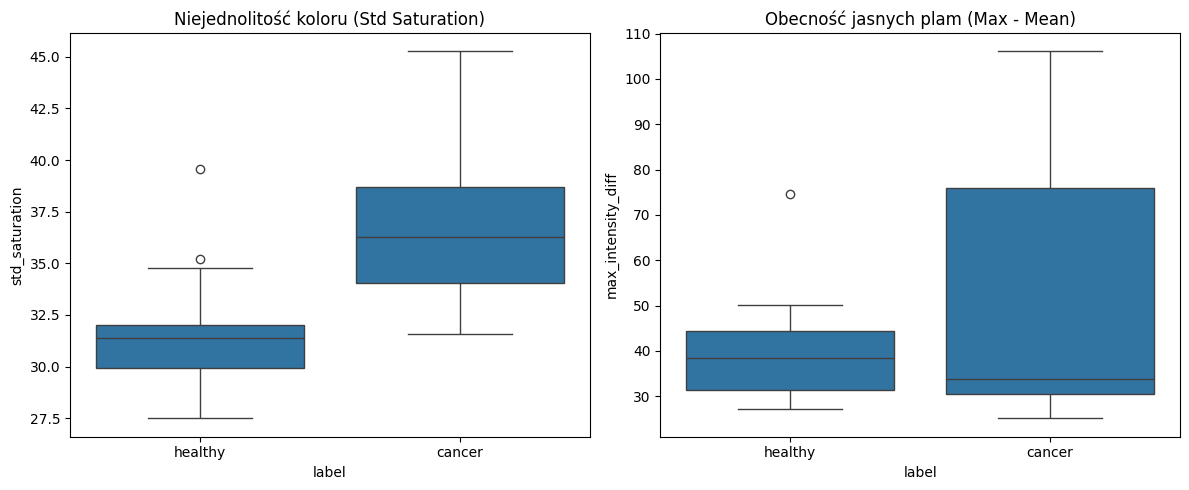

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='std_saturation', data=df_all)
plt.title("Niejednolitość koloru (Std Saturation)")

plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='max_intensity_diff', data=df_all)
plt.title("Obecność jasnych plam (Max - Mean)")

plt.tight_layout()
plt.show()